# LDA (Latent Dirichlet Allocation) 
LDA is used for topic discovery. The following assumptions are necessary in order for this algorithm to be used:
1. The semantic content of a document is composed by combining one or more terms from one or more topics.
2. Certain terms are ambiguous, belonging to more than one topic, with different probability. However, in a document, the accompanying presence of specific neighboring terms (which belong to only one topic) will disambiguate their usage.
3. Most documents will contain only a relatively small number of topics. In the collection, individual topics will occur with differing frequencies. That is, they have a probability distribution, so that a given document is more likely to contain some topics than others.
4. Within a topic, certain terms will be used much more frequently than others. In other words, the terms within a topic will also have their own probability distribution.

In [1]:
from itertools import *
import numpy as np
import pandas as pd
from collections import Counter
import re
import os
import sys

from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set()  


import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
words = set(nltk.corpus.words.words())
#!{sys.executable} -m pip install pyLDAvis.gensim
from stop_words import get_stop_words
from gensim import corpora, models
from gensim.corpora import Dictionary
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec

import pyLDAvis
import pyLDAvis.gensim_models

[nltk_data] Downloading package stopwords to /home/kbari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kbari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Extract project descriptions from each document
Currently extracts 2941/3205 project descriptions (91%)

In [2]:
## Path to text files
path = "/home/kbari/git_repo/FinanceErdosProj/PyMuPdf_Text/"
path1 = "/home/kbari/git_repo/FinanceErdosProj/Tesseract_Text/"

## Load from txt from files to a dataframe; Other information to include possibly?

#pd.read_table(file,header=None,quotechar=None,quoting=3,error_bad_lines=False) for file in DIR]
def txt_to_df(path):
    ''' Put all txt files into single dataframe'''
    DIR = os.listdir(path)
    raw_df_lst = []
    for i in range(len(DIR)):
        with open(path+DIR[i],encoding = "ISO-8859-1") as f:
            lines = f.readlines()
            data = '\n'.join(map(str,lines))
            #print(DIR[i])
            p = proj_desc_preprocess(data)
            if p is not None:
                p = p.replace("\n","")
                l = len(p)
            else:
                l = 0
            di= pd.DataFrame([data,p,int(l)],index=['raw_text','proj_desc','num_char'],columns=[DIR[i]]).T
            raw_df_lst.append(di)
    #print(len(raw_df_lst))
    df_raw = pd.concat(raw_df_lst)
    return df_raw

## Grab Project Description   
def proj_desc_preprocess(text):
    ''' Grab Project Description'''
    if len(re.findall('Project Description',text,re.IGNORECASE)) > 0:
        start = 'Project Description'
        end = 'SCHEDULE'
        try:
            return text.split(start)[1].split(end)[0]
        except:
            return None
    elif len(re.findall('Description of the Project',text,re.IGNORECASE)) > 0:
        start = 'Description of the Project'
        end = 'SCHEDULE'
        try:
            return text.split(start)[1].split(end)[0]
        except:
            return None
    elif len(re.findall('Program Actions',text,re.IGNORECASE)) > 0:
        start = 'Program Actions'
        end = 'Section II'
        try:
            return text.split(start)[1].split(end)[0]
        except:
            return None
    elif len(re.findall('Schedule 3',text,re.IGNORECASE)) > 0:
        start = 'SCHEDULE 3'
        #end = 'SCHEDULE 3'
        try:
            return text.split(start)[1]
        except:
            return None
    elif len(re.findall('Schedule III',text,re.IGNORECASE)) > 0:
        start = 'SCHEDULE III'
        #end = 'SCHEDULE 3'
        try:
            return text.split(start)[1]
        except:
            return None
    else:
        #print('CASE 4')
        return None


df = txt_to_df(path)
df1 = txt_to_df(path1)
dF = pd.concat([df,df1])
## Drop null proj desc
dG = dF.dropna()

### Explore project description lengths and common words

In [3]:
document_lengths = np.array(list(map(len, dG.proj_desc.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 580.2393743624617.
The minimum number of words in a document is: 19.
The maximum number of words in a document is: 6603.


/home/kbari/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


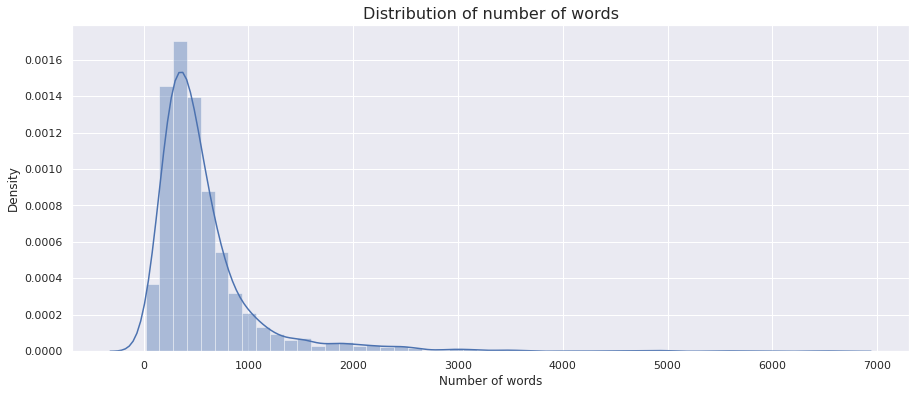

In [4]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax);

### Function to tokenize texts. Additionally removes punctuation, numeric terms, non-english terms, non-english characters then lemmatizes.

In [5]:
W = ['principal','amount','withdrawal','withdrawn','subject','plan','taken','least','schedule','training','carrying','technical','capacity','following','agree','upon','said','part','made','paragraph','implementation','borrower','date','strengthen','assistance','support','january','february','march','april','may','june','july','august','september','october','november','december','for','management','section','id','the','payment','objective','improvement','provision','bank','project','system','program','sector','time','loan','development','shall','set','forth','agreement','general','improve','improvement','down','strengthening']


def text_preprocess(text):
    '''
    Remove all punctuation,stopwords, non-english words, numbers, lemmatize -> returns list of words
    '''
    stemmer = WordNetLemmatizer()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    nopunc =  [word for word in nopunc.split() if word.isalnum()]
    nopunc =  [word.lower() for word in nopunc if word not in stopwords.words('english')]
    nopunc =  [word for word in nopunc if len(word)>2]
    nopunc = [word for word in nopunc if word not in W]
    nopunc = [w for w in nopunc if w.lower() in words or not w.isalpha()]
    return [stemmer.lemmatize(word) for word in nopunc]

In [6]:
docLabels= dG.index
data = dG.proj_desc

### Example to see how processing performs

In [7]:
i = 2632
print(data[i])
print(text_preprocess(data[i]))

The objectives of the Project are to contribute to the improvement of theinvestment climate and to foster enterprise development in the Borrowerâs territory.The Project consists of the following parts:Part A. Institutional Development to Improve Business Climate1.Contribution to the Design of ANPI-GabonCarrying out a program of activities aimed at building the operational capacity ofANPI-Gabon through: (a) the development of: (1) required operational toolsincluding strategic plans, business plans, a communication strategy, and anyother necessary documents for ANPI-Gabonâs operations; (ii) Training in skillsrequired for investment assistance; and (iii) awareness campaigns; and(b) provision of goods required for the purpose.Promoting Investments in Targeted SectorsDeveloping the Borrowerâs investment promotion capacity to effectively performits investment promotion and outreach role, through the: (a) provision oftechnical assistance to develop and implement investment promotion and

### Add column of processed text as well as create bag of words for each

In [8]:
## Add column of processed textx
def lem_stem(df):
    df['stem'] = list(map(lambda sentence: text_preprocess(sentence),df.proj_desc))
    
lem_stem(dG)

<ipython-input-8-b5e94ccd7d16>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stem'] = list(map(lambda sentence: text_preprocess(sentence),df.proj_desc))


### Word frequency

/home/kbari/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


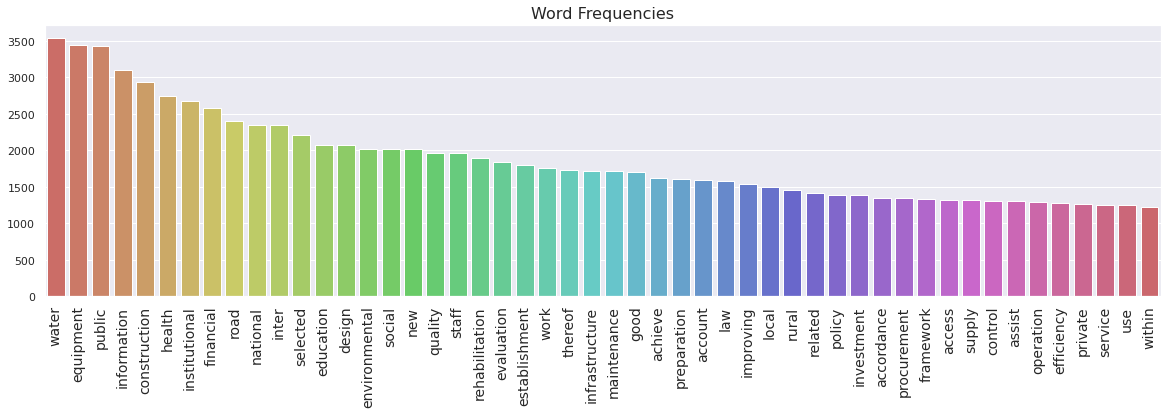

In [9]:
token_dict = Counter(np.concatenate(dG.stem.values))

token_df = pd.DataFrame.from_dict(token_dict, orient='index')
token_df.rename(columns={0: 'count'}, inplace=True)
token_df.sort_values('count', ascending=False, inplace=True)

def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(token_df)
ax.set_title("Word Frequencies", fontsize=16);

In [10]:
dictionary = Dictionary(documents=dG.stem.values)

print("Found {} words.".format(len(dictionary.values())))

Found 7516 words.


In [11]:
dictionary.filter_extremes(no_above=0.8, no_below=3)

dictionary.compactify() 
print("Left with {} words.".format(len(dictionary.values())))

Left with 4282 words.


### Create column for bag of words to run LDA

In [12]:
# Bag of Words for each lemmatized document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stem))
    
document_to_bow(dG)

<ipython-input-12-a5d55fe16328>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stem))


## Train LDA Model on 2941 documents

In [13]:
corpus = dG.bow
num_topics = 11

In [14]:
%%time
#LDA multicore approach
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

CPU times: user 26 s, sys: 921 ms, total: 26.9 s
Wall time: 26.5 s


In [15]:
LDAmodel.print_topics()

[(0,
  '0.021*"law" + 0.012*"official" + 0.011*"gazette" + 0.011*"decree" + 0.009*"year" + 0.008*"proceeds" + 0.008*"national" + 0.008*"public" + 0.008*"currency" + 0.007*"budget"'),
 (1,
  '0.018*"education" + 0.016*"information" + 0.013*"inter" + 0.012*"social" + 0.012*"evaluation" + 0.011*"rural" + 0.011*"public" + 0.010*"quality" + 0.010*"institutional" + 0.009*"selected"'),
 (2,
  '0.033*"power" + 0.017*"construction" + 0.016*"equipment" + 0.013*"electricity" + 0.012*"transport" + 0.010*"transmission" + 0.009*"new" + 0.009*"achieve" + 0.009*"thereof" + 0.009*"installation"'),
 (3,
  '0.029*"irrigation" + 0.017*"equipment" + 0.015*"education" + 0.014*"water" + 0.010*"land" + 0.010*"staff" + 0.010*"gas" + 0.009*"achieve" + 0.009*"establishment" + 0.009*"thereof"'),
 (4,
  '0.064*"road" + 0.024*"maintenance" + 0.020*"safety" + 0.017*"equipment" + 0.016*"work" + 0.015*"rehabilitation" + 0.012*"construction" + 0.011*"staff" + 0.011*"transport" + 0.010*"network"'),
 (5,
  '0.026*"financ

## Visualize output of model
Adjusting lambda to values close to 0 highlights potentially rare but more exclusive terms for the selected topic. Larger lambda values (closer to 1) highlight more frequently occurring terms in the document that might not be exclusive to the topic. 
http://www.kennyshirley.com/LDAvis/

In [16]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(LDAmodel, corpus, dictionary)
vis

/home/kbari/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.050735 -0.096746       1        1  18.436010
0      0.209575 -0.059080       2        1  15.217038
8     -0.110833  0.044477       3        1  13.709839
5      0.042250 -0.120572       4        1  10.526101
9      0.322299  0.102175       5        1   8.792288
4     -0.065680  0.014903       6        1   7.370267
7     -0.036280 -0.116458       7        1   6.978090
2     -0.075715  0.083009       8        1   5.728290
6     -0.097533  0.098959       9        1   5.328401
3     -0.086167  0.006243      10        1   4.776621
10    -0.051181  0.043091      11        1   3.137055, topic_info=             Term         Freq        Total Category  logprob  loglift
321        health  2609.000000  2609.000000  Default  30.0000  30.0000
825          road  2326.000000  2326.000000  Default  29.0000  29.0000
396         water  3374.000000  3374.000000  Default  28.0000  28.0000
543       account  1588.000000  1588.000000  Default  27.0000  27.0000
13   construction  2799.000000  2799.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
13   construction    80.903120  2799.545551  Topic11  -5.0380  -0.0821
496    protection    68.981933   699.976456  Topic11  -5.1974   1.1447
505         state    70.366412   902.862501  Topic11  -5.1775   0.9100
889  agricultural    68.421816   850.958502  Topic11  -5.2055   0.9412
55    preparation    69.760896  1601.820609  Topic11  -5.1862   0.3281

[848 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
667       1  0.067413  acceptable
667       2  0.238096  acceptable
667       3  0.073150  acceptable
667       4  0.048767  acceptable
667       5  0.443203  acceptable
...     ...       ...         ...
81        2  0.008594       youth
81        3  0.051565       youth
81        6  0.008594       youth
81        7  0.034377       youth
81       10  0.008594       youth

[3787 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 9, 6, 10, 5, 8, 3, 7, 4, 11])

## Predict Topics for Document

In [17]:
def lda_predict(doc):
    ''' Displays distribution of topics within corpus document'''
    s = text_preprocess(doc)
    b = list(dictionary.doc2bow(s))
    p = list(LDAmodel[b])
    topics = sorted(p,key=lambda x:x[1],reverse=True)
    return topics

print(data[0])
p = lda_predict(data[0])
print(p)

  The objective of the Project is to improve the living conditions and the social inclusion of the most disadvantaged and vulnerable people in Romania.   The Project consists of the following parts:  Part I: Priority Interventions ProgramSupport to RSDF to improve living conditions and social inclusion for Roma living in about one hundred (100) poor settlements through: (i) the financing of Priority Interventions Sub-projects awarded on a competitive basis; (ii) the carrying out of promotion, information and education campaigns and monitoring evaluation activities, and the provision of training for local authorities, community groups and NGOs; (iii) the provision of assistance in capacity building at community level through preparation, facilitation, evaluation and supervision of Priority Intervention Sub-projects and provision of training in relation thereto, including training to RSDF; and (iv) the provision of technical assistance to poor Roma communities to prepare projects to be f

In [18]:
# tokenized_only_dict = Counter(np.concatenate(dG.tokenized_text.values))

# tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
# tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

In [19]:
# tokenized_only_df.sort_values('count', ascending=False, inplace=True)

In [20]:
# dictionary = Dictionary(documents=dG.stemmed_text.values)

In [21]:
# cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
# cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

# cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
# del cleansed_words_df['id']

# cleansed_words_df.sort_values('count', ascending=False, inplace=True)

In [22]:
# fig, ax = plt.subplots(figsize=(15,6))

# ax.set_title("Distribution of number of words", fontsize=16)
# ax.set_xlabel("Number of words")
# sns.distplot(document_lengths, bins=50, ax=ax);

In [23]:
# def get_good_tokens(sentence):
#     replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
#     removed_punctation = list(filter(lambda token: token, replaced_punctation))
#     return removed_punctation

In [24]:
# def lda_get_good_tokens(df):
#     df['text'] = df.proj_desc.str.lower()
#     df['tokenized_text'] = list(map(nltk.word_tokenize, df.proj_desc))
#     df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

# lda_get_good_tokens(dG)

In [25]:
# tokenized_only_dict = Counter(np.concatenate(dG.stem.values))

# tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
# tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

# tokenized_only_df.sort_values('count', ascending=False, inplace=True)

# # I made a function out of this since I will use it again later on 
# def word_frequency_barplot(df, nr_top_words=50):
#     """ df should have a column named count.
#     """
#     fig, ax = plt.subplots(1,1,figsize=(20,5))

#     sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

#     ax.set_xticks(list(range(nr_top_words)))
#     ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
#     return ax
    
# ax = word_frequency_barplot(tokenized_only_df)
# ax.set_title("Word Frequencies", fontsize=16);

In [26]:
# def remove_stopwords(df):
#     """ Removes stopwords based on a known set of stopwords
#     available in the nltk package. In addition, we include our
#     made up word in here.
#     """
#     # Luckily nltk already has a set of stopwords that we can remove from the texts.
#     stopwords = nltk.corpus.stopwords.words('english')
#     # we'll add our own special word in here 'qwerty'
#     stopwords.append('the')

#     df['stopwords_removed'] = list(map(lambda doc:
#                                        [word for word in doc if word not in stopwords],
#                                        df['tokenized_text']))

# remove_stopwords(dG)


# def stem_words(df):
#     lemm = nltk.stem.WordNetLemmatizer()
#     df['lemmatized_text'] = list(map(lambda sentence:
#                                      list(map(lemm.lemmatize, sentence)),
#                                      df.stopwords_removed))

#     p_stemmer = nltk.stem.porter.PorterStemmer()
#     df['stemmed_text'] = list(map(lambda sentence:
#                                   list(map(p_stemmer.stem, sentence)),
#                                   df.lemmatized_text))

# stem_words(dG)

In [27]:
# dictionary = Dictionary(documents=dG.stemmed_text.values)

# print("Found {} words.".format(len(dictionary.values())))

In [28]:
# dictionary.filter_extremes(no_above=0.8, no_below=3)

# dictionary.compactify()  # Reindexes the remaining words after filtering
# print("Left with {} words.".format(len(dictionary.values())))

In [29]:
# #Make a BOW for every document
# def document_to_bow(df):
#     df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
# document_to_bow(dG)

In [30]:
# # we make a function such that later on when we make the submission, we don't need to write duplicate code
# def lda_preprocessing(df):
#     """ All the preprocessing steps for LDA are combined in this function.
#     All mutations are done on the dataframe itself. So this function returns
#     nothing.
#     """
#     lda_get_good_tokens(df)
#     remove_stopwords(df)
#     stem_words(df)
#     document_to_bow(df)

In [31]:
# cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
# cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

# cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
# del cleansed_words_df['id']

# cleansed_words_df.sort_values('count', ascending=False, inplace=True)

In [32]:
#ax = word_frequency_barplot(cleansed_words_df)
#ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);

In [33]:
#def stem_words(df):
#    lemm = nltk.stem.WordNetLemmatizer()
#    df['lemmatized_text'] = list(map(lambda sentence:
#                                     list(map(lemm.lemmatize, sentence)),
#                                     df.stopwords_removed))
#
#    p_stemmer = nltk.stem.porter.PorterStemmer()
#    df['stemmed_text'] = list(map(lambda sentence:
#                                  list(map(p_stemmer.stem, sentence)),
#                                  df.lemmatized_text))

In [34]:
#tokenizer = RegexpTokenizer(r'\w+')
#en_stop = get_stop_words('en')
#p_stemmer = PorterStemmer()

#def text_preprocess(text):
#    tokens = tokenizer.tokenize(text.lower())
#    t = [i for i in tokens if not i in en_stop]	
#    t1 = [p_stemmer.stem(i) for i in t]
#    return t1


### Removes punctuation, stopwords, lemmatizes
#def text_preprocess(text):
#    '''
#    Remove all punctuation,stopwords, lemmatize -> returns list of words
#    '''
#    stemmer = WordNetLemmatizer()
#    nopunc = [char for char in text if char not in string.punctuation]
#    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
#    nopunc =  [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
#    nopunc = [w for w in nopunc if w.lower() in words or not w.isalpha()]
#    return [stemmer.lemmatize(word) for word in nopunc]

#T = [ text_preprocess(t) for t in dG.proj_desc]